In [1]:
# import
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

import numpy
import tkinter
from tkinter import filedialog
import torch
import torch.nn
from torch import optim
import torch.nn.functional
import matplotlib.pyplot
import matplotlib.ticker
import datetime
from torch.autograd import Variable

In [48]:
# variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS = 0
EOS = 1

USE_TEACHER_FORCING = False
TEACHER_FORCING_RATIO = 1.0

LEARNING_RATE = 0.05

HIDDEN_SIZE = 256
VOCABULARY_SIZE = 28
LATENT_SIZE = 32
DROPOUT = 0.1

ITERS = 50000
REMIDER = 100

MAX_LENGTH = 2  # update in dataloader

In [24]:
# support function
EMPTY_INPUT_RATIO = 0.1
KLG_WRIGHT = 0.0


#compute BLEU-4 score
def computeBleu(output, reference):
    cc = SmoothingFunction()
    return sentence_bleu([reference],
                         output,
                         weights=(0.25, 0.25, 0.25, 0.25),
                         smoothing_function=cc.method1)


def GaussianScore(words):
    wordsList = []
    score = 0
    with open(fileName, 'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            wordsList.extend([word])
        for t in words:
            for i in wordsList:
                if t == i:
                    score += 1
    return score / len(words)


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Data Processing

In [25]:
class customClass:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # 字典

    # 新增單字
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    # 更新字典
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [26]:
# 轉換資料型態成Model可以使用的Tensor
def pairToTensor(pair):
    # 輸入完整句子(pair) >>> je suis dans le petrin .
    # 切割並轉換成字典編碼 >>> ['je', 'suis', 'dans', 'le', 'petrin', '.']
    # 加入EOS標籤，轉換型態(list->Tensor)，並Reshape((N)->[N*1]) >>> [6, 11, 296, 44, 972, 5]
    inputTensor = [InputClass.word2index[word] for word in pair[0].split(' ')]
    inputTensor.append(EOS)
    inputTensor = torch.tensor(
        inputTensor, dtype=torch.long, device=device).view(-1, 1)

    targetTensor = [
        OutputClass.word2index[word] for word in pair[1].split(' ')
    ]
    targetTensor.append(EOS)
    targetTensor = torch.tensor(
        targetTensor, dtype=torch.long, device=device).view(-1, 1)
    pairTensor = (inputTensor, targetTensor)

    return pairTensor

In [49]:
# dataloader
# select file and set fileName
MAX_LENGTH = 30
Pairs = []

root = tkinter.Tk()
root.withdraw()
root.wm_attributes("-topmost", 1)
fileName = filedialog.askopenfilename(
    parent=root,
    title="Choose Data File",
    filetypes=[("Data", "*.txt")],
    multiple=False)

# read fileData
fileData = open(fileName, 'r')
InputClass = customClass('inputClass')
OutputClass = customClass('targetClass')
for tenseData in fileData.readlines():
    tense = tenseData.replace('\n', '').split(' ')
    for i in range(len(tense)):
        data = tense[i]
        Pairs.append([data, data])
        InputClass.addSentence(data)
        OutputClass.addSentence(data)
#         if len(data) > MAX_LENGTH:
#             MAX_LENGTH = len(data)
fileData.close()

# MAX_LENGTH += 2
# print('MAX_LENGTH', MAX_LENGTH)
print('[[', InputClass.name, ',', OutputClass.name, ']]')
Pairs

[[ inputClass , targetClass ]]


[['abandon', 'abandon'],
 ['abandons', 'abandons'],
 ['abandoning', 'abandoning'],
 ['abandoned', 'abandoned'],
 ['abet', 'abet'],
 ['abets', 'abets'],
 ['abetting', 'abetting'],
 ['abetted', 'abetted'],
 ['abdicate', 'abdicate'],
 ['abdicates', 'abdicates'],
 ['abdicating', 'abdicating'],
 ['abdicated', 'abdicated'],
 ['abduct', 'abduct'],
 ['abducts', 'abducts'],
 ['abducting', 'abducting'],
 ['abducted', 'abducted'],
 ['abound', 'abound'],
 ['abounds', 'abounds'],
 ['abounding', 'abounding'],
 ['abounded', 'abounded'],
 ['absorb', 'absorb'],
 ['absorbs', 'absorbs'],
 ['absorbing', 'absorbing'],
 ['absorbed', 'absorbed'],
 ['accept', 'accept'],
 ['accepts', 'accepts'],
 ['accepting', 'accepting'],
 ['accepted', 'accepted'],
 ['accompany', 'accompany'],
 ['accompanies', 'accompanies'],
 ['accompanying', 'accompanying'],
 ['accompanied', 'accompanied'],
 ['accomplish', 'accomplish'],
 ['accomplishes', 'accomplishes'],
 ['accomplishing', 'accomplishing'],
 ['accomplished', 'accomplished

In [28]:
# conditions
conditions = torch.Tensor(numpy.zeros((4, 4)))
for i in range(len(conditions)):
    for j in range(len(conditions[i])):
        conditions[i][i] = 1
conditions

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

# Seq2Seq Model

In [29]:
# 編碼器：
# 輸入：一次一個字母(sourceTense) & 前一個隱藏資訊
# 輸出：壓縮後的資料 & 隱藏資訊
class EncoderRNN(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(EncoderRNN, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = torch.nn.Embedding(inputSize, hiddenSize)
        self.gru = torch.nn.GRU(hiddenSize, hiddenSize)

        self.linear = torch.nn.Linear(self.hiddenSize + 4, self.hiddenSize)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)

        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    # concatenate the condition part with the initial hidden part as input
    def initHidden(self, condition):
        initHidden = torch.zeros(1, 1, self.hiddenSize, device=device)
        initCondition = conditions[condition].view(1, 1, -1).to(device)

        initHidden = torch.cat((initHidden, initCondition), dim=2)
        initHidden = self.linear(initHidden)
        return initHidden

In [30]:
# 解碼器：
# 輸入：一次一個字母(sourceTense) & 前一個隱藏資訊
# 輸出：壓縮後的資料(解碼後即為targetTense) & 隱藏資訊
# ※有使用softmax function
class DecoderRNN(torch.nn.Module):
    def __init__(self, hiddenSize, outputSize):
        super(DecoderRNN, self).__init__()
        self.hiddenSize = hiddenSize

        self.embedding = torch.nn.Embedding(outputSize, hiddenSize)
        self.gru = torch.nn.GRU(hiddenSize, hiddenSize)
        self.out = torch.nn.Linear(hiddenSize, outputSize)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    # concatenate the condition part with the initial hidden part as input
    def initHidden(self, condition):
        initHidden = torch.zeros(1, 1, self.hiddenSize, device=device)
        initCondition = conditions[condition].view(1, 1, -1).to(device)

        initHidden = torch.cat((initHidden, initCondition), dim=2)
        return initHidden

In [31]:
# Attention解碼器：將解碼器的輸入乘上一組權重，以幫助解碼器選擇正確的輸出類別
# soft輸入：依基率選擇部分解碼器輸出的隱藏資訊


class AttnDecoderRNN(torch.nn.Module):
    def __init__(self, hiddenSize, outputSize):
        super(AttnDecoderRNN, self).__init__()
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.dropout_p = DROPOUT
        self.maxLength = MAX_LENGTH  # 最長的句子

        self.embedding = torch.nn.Embedding(self.outputSize, self.hiddenSize)
        self.attn = torch.nn.Linear(self.hiddenSize * 2, self.maxLength)
        self.attnCombine = torch.nn.Linear(self.hiddenSize * 2,
                                           self.hiddenSize)
        self.dropout = torch.nn.Dropout(self.dropout_p)
        self.gru = torch.nn.GRU(self.hiddenSize, self.hiddenSize)
        self.out = torch.nn.Linear(self.hiddenSize, self.outputSize)

        self.linear = torch.nn.Linear(self.hiddenSize + 4, self.hiddenSize)

    def forward(self, input, hidden, encoderOutputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attnWeights = torch.nn.functional.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attnApplied = torch.bmm(
            attnWeights.unsqueeze(0), encoderOutputs.unsqueeze(0))

        output = torch.cat((embedded[0], attnApplied[0]), 1)

        output = self.attnCombine(output).unsqueeze(0)

        output = torch.nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)

        output = torch.nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attnWeights

    # concatenate the condition part with the initial hidden part as input
    def initHidden(self, encoderHidden, condition):
        encoderHidden = encoderHidden
        initCondition = conditions[condition].view(1, 1, -1).to(device)

        initHidden = torch.cat((encoderHidden, initCondition), dim=2)
        initHidden = self.linear(initHidden)
        return initHidden

In [32]:
# Latent Layer
class LatentLayer(torch.nn.Module):
    def __init__(self, hiddenSize, latentSize):
        super(LatentLayer, self).__init__()
        self.hiddenSize = hiddenSize
        self.latentSize = latentSize

        self.linear1 = torch.nn.Linear(hiddenSize + 4, 128)
        self.linear2 = torch.nn.Linear(128, 64)
        self.linear3 = torch.nn.Linear(64, latentSize)

        self.linear4 = torch.nn.Linear(latentSize, 64)
        self.linear5 = torch.nn.Linear(64, 128)
        self.linear6 = torch.nn.Linear(128, hiddenSize + 4)

    def forward(self, latent):
        # encoder hidden layer
        latent = self.linear1(latent)
        latent = self.linear2(latent)
        latent = self.linear3(latent)

        # VAE
        standardDeviation = latent
        standardDeviation = torch.exp(0.5 * standardDeviation)
        eps = torch.rand_like(standardDeviation)
        mu = latent
        z = eps.mul(standardDeviation).add_(mu)

        # decoder hidden layer
        latent = self.linear4(z)
        latent = self.linear5(latent)
        latent = self.linear6(latent)
        latent = torch.sigmoid(latent)

        return latent

# Train Model

In [43]:
# train model
def train(inputTensor,
          targetTensor,
          condition,
          encoder,
          decoder,
          encoderOptimizer,
          decoderOptimizer,
          criterion,
          maxLength=MAX_LENGTH):

    encoder = encoder.train()
    decoder = decoder.train()

    encoderHidden = encoder.initHidden(condition)

    encoderOptimizer.zero_grad()
    decoderOptimizer.zero_grad()

    inputLength = inputTensor.size(0)
    targetLength = targetTensor.size(0)

    encoderOutputs = torch.zeros(maxLength, encoder.hiddenSize, device=device)

    loss = 0

    for i in range(inputLength):
        encoderOutput, encoderHidden = encoder(inputTensor[i], encoderHidden)
        encoderOutputs[i] = encoderOutput[0, 0]

    decoderInput = torch.tensor([[SOS]], device=device)

    # VAE
    #     encoderHidden = encoderHidden.to(device)
    #     latentHidden = latentLayer(encoderHidden)

    #     decoderHidden = decoder.initHidden(latentHidden, condition)
    decoderHidden = encoderHidden

    USE_TEACHER_FORCING = True if random.random(
    ) < TEACHER_FORCING_RATIO else False

    if USE_TEACHER_FORCING:
        # Teacher forcing: Feed the target as the next input
        for i in range(targetLength):
            decoderOutput, decoderHidden, decoderAttention = decoder(
                decoderInput, decoderHidden, encoderOutputs)
            loss += criterion(decoderOutput, targetTensor[i])
            decoderInput = targetTensor[i]  # Teacher forcing

    else:
        # Without teacher forcing: use its own preictions as the next input
        for i in range(targetLength):
            decoderOutput, decoderHidden, decoderAttention = decoder(
                decoderInput, decoderHidden, encoderOutputs)
            topv, topi = decoderOutput.topk(1)
            decoderInput = topi.squeeze().detach(
            )  # detach from history as input

            loss += criterion(decoderOutput, targetTensor[i])
            if decoderInput.item() == EOS:
                break

    loss.backward()

    encoderOptimizer.step()
    decoderOptimizer.step()

    return loss.item() / targetLength


# epoch
def trainIters(encoder, decoder, lossArray):
    #     lossArray = []
    printLossSum = 0  # Reset every print_every
    plotLossSum = 0  # Reset every plot_every

    encoderOptimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
    decoderOptimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)
    trainingPairs = [pairToTensor(random.choice(Pairs)) for i in range(ITERS)]
    criterion = torch.nn.NLLLoss()

    for iters in range(1, ITERS + 1):
        trainPair = trainingPairs[iters - 1]
        inputTensor = trainPair[0]
        targetTensor = trainPair[1]

        # condition
        condition = (iters - 1) % 4

        loss = train(inputTensor, targetTensor, condition, encoder, decoder,
                     encoderOptimizer, decoderOptimizer, criterion)
        printLossSum += loss
        plotLossSum += loss

        if iters % REMIDER == 0:
            print_loss_avg = printLossSum / REMIDER
            printLossSum = 0
            print('(%d\t%d%%)\t%.4f' % (iters, iters / ITERS * 100,
                                        print_loss_avg))

            plotLossMean = plotLossSum / REMIDER
            lossArray.append(plotLossMean)
            plotLossSum = 0

# Evaluate Function

In [34]:
def plotResult(plotArray, name):
    matplotlib.pyplot.plot(plotArray, label=name, color='#0000FF')
    matplotlib.pyplot.legend(loc='best')
    matplotlib.pyplot.show()
    matplotlib.pyplot.clf()

In [44]:
def evaluate(encoder, decoder, condition, sentence, maxLength=MAX_LENGTH):
    with torch.no_grad():
        # 輸入完整句子 > 切割字典片段 > 轉換成字典編碼
        inputTensor = [
            InputClass.word2index[word] for word in sentence.split(' ')
        ]
        # 加入EOS標籤
        inputTensor.append(EOS)
        # 轉換型態(list->Tensor)並Reshape((N)->[N*1])
        inputTensor = torch.tensor(
            inputTensor, dtype=torch.long, device=device).view(-1, 1)

        inputLength = inputTensor.size()[0]
        encoderHidden = encoder.initHidden(condition)

        encoderOutputs = torch.zeros(
            maxLength, encoder.hiddenSize, device=device)

        for i in range(inputLength):
            encoderOutput, encoderHidden = encoder(inputTensor[i],
                                                   encoderHidden)
            encoderOutputs[i] += encoderOutput[0, 0]

        decoderInput = torch.tensor([[SOS]], device=device)  # SOS

        # VAE
        #         encoderHidden = encoderHidden.to(device)
        #         latentHidden = latentLayer(encoderHidden)

        #         decoderHidden = decoder.initHidden(latentHidden, condition)
        decoderHidden = encoderHidden

        decodedWords = []
        decoderAttentions = torch.zeros(maxLength, maxLength)

        for i in range(maxLength):
            decoderOutput, decoderHidden, decoderAttention = decoder(
                decoderInput, decoderHidden, encoderOutputs)
            decoderAttentions[i] = decoderAttention.data
            topv, topi = decoderOutput.data.topk(1)
            if topi.item() == EOS:
                decodedWords.append('<EOS>')
                break
            else:
                decodedWords.append(OutputClass.index2word[topi.item()])

            decoderInput = topi.squeeze().detach()

        return decodedWords, decoderAttentions[:i + 1]

# Training Result

(100	0%)	4.6684
(200	0%)	4.2996
(300	0%)	4.2819
(400	0%)	4.2508
(500	1%)	4.2813
(600	1%)	4.2621
(700	1%)	4.2413
(800	1%)	4.2514
(900	1%)	4.2384
(1000	2%)	4.2369
(1100	2%)	4.2372
(1200	2%)	4.1891
(1300	2%)	4.2108
(1400	2%)	4.2379
(1500	3%)	4.1905
(1600	3%)	4.2089
(1700	3%)	4.2153
(1800	3%)	4.2028
(1900	3%)	4.2006
(2000	4%)	4.1896
(2100	4%)	4.1874
(2200	4%)	4.1682
(2300	4%)	4.1746
(2400	4%)	4.1905
(2500	5%)	4.1851
(2600	5%)	4.1599
(2700	5%)	4.1610
(2800	5%)	4.1583
(2900	5%)	4.1639
(3000	6%)	4.1699
(3100	6%)	4.1369
(3200	6%)	4.1206
(3300	6%)	4.1175
(3400	6%)	4.1063
(3500	7%)	4.1074
(3600	7%)	4.0803
(3700	7%)	4.0759
(3800	7%)	4.1147
(3900	7%)	4.0501
(4000	8%)	4.0911
(4100	8%)	4.0632
(4200	8%)	3.9952
(4300	8%)	3.9162
(4400	8%)	3.9365
(4500	9%)	3.8726
(4600	9%)	3.8091
(4700	9%)	3.7631
(4800	9%)	3.8143
(4900	9%)	3.8184
(5000	10%)	3.6606
(5100	10%)	3.7124
(5200	10%)	3.5833
(5300	10%)	3.7872
(5400	10%)	3.5933
(5500	11%)	3.6144
(5600	11%)	3.4628
(5700	11%)	3.5333
(5800	11%)	3.4713
(5900	11%)	3.3

(44100	88%)	0.0052
(44200	88%)	0.0060
(44300	88%)	0.0162
(44400	88%)	0.0200
(44500	89%)	0.0058
(44600	89%)	0.0054
(44700	89%)	0.0052
(44800	89%)	0.0050
(44900	89%)	0.0052
(45000	90%)	0.0113
(45100	90%)	0.0052
(45200	90%)	0.0050
(45300	90%)	0.0052
(45400	90%)	0.0048
(45500	91%)	0.0052
(45600	91%)	0.0050
(45700	91%)	0.0055
(45800	91%)	0.0048
(45900	91%)	0.0055
(46000	92%)	0.0049
(46100	92%)	0.0078
(46200	92%)	0.0050
(46300	92%)	0.0054
(46400	92%)	0.0047
(46500	93%)	0.0052
(46600	93%)	0.0050
(46700	93%)	0.0052
(46800	93%)	0.0048
(46900	93%)	0.0045
(47000	94%)	0.0049
(47100	94%)	0.0050
(47200	94%)	0.0096
(47300	94%)	0.0049
(47400	94%)	0.0052
(47500	95%)	0.0050
(47600	95%)	0.0046
(47700	95%)	0.0046
(47800	95%)	0.0048
(47900	95%)	0.0054
(48000	96%)	0.0046
(48100	96%)	0.0046
(48200	96%)	0.0045
(48300	96%)	0.0048
(48400	96%)	0.0045
(48500	97%)	0.0045
(48600	97%)	0.0050
(48700	97%)	0.0068
(48800	97%)	0.0046
(48900	97%)	0.0076
(49000	98%)	0.0046
(49100	98%)	0.0045
(49200	98%)	0.0051
(49300	98%)	

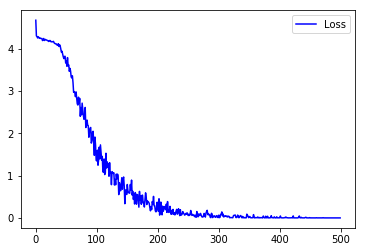

<Figure size 432x288 with 0 Axes>

In [50]:
# training model
# InputClass, OutputClass, Pairs = prepareData('ST', 'TP')
# Input: pair data [[A1,B1],[A2,B2]]
lossArray = []

encoderRNN = EncoderRNN(InputClass.n_words, HIDDEN_SIZE).to(device)
attnDecoderRNN = AttnDecoderRNN(HIDDEN_SIZE, OutputClass.n_words).to(device)
# latentLayer = LatentLayer(HIDDEN_SIZE, LATENT_SIZE).to(device)

trainIters(encoderRNN, attnDecoderRNN, lossArray)

plotResult(lossArray, 'Loss')

In [51]:
# show all results
count = 0
print(" T/F    ", "%-20s" % ' Input', "%-20s" % ' Target',
      "%-20s" % ' Predict')
for i in range(len(Pairs)):
    pair = Pairs[i]
    condition = i % 4
    output_words, attentions = evaluate(encoderRNN, attnDecoderRNN, condition,
                                        pair[0])
    output_sentence = ' '.join(output_words)[:-6]

    if pair[1] == output_sentence:
        count += 1
        print("True    ", "%-20s" % pair[0], "%-20s" % pair[1],
              "%-20s" % output_sentence)
#     else:
#         print("False   ", "%-20s" % pair[0], "%-20s" % pair[1],
#               "%-20s" % output_sentence)
print('Accuracy:', count / len(Pairs) * 100, "%")

 T/F      Input                Target               Predict            
True     abandon              abandon              abandon             
True     abandons             abandons             abandons            
True     abandoning           abandoning           abandoning          
True     abandoned            abandoned            abandoned           
True     abet                 abet                 abet                
True     abets                abets                abets               
True     abetting             abetting             abetting            
True     abetted              abetted              abetted             
True     abdicate             abdicate             abdicate            
True     abdicates            abdicates            abdicates           
True     abdicating           abdicating           abdicating          
True     abdicated            abdicated            abdicated           
True     abduct               abduct               abduct       

True     advocated            advocated            advocated           
True     affect               affect               affect              
True     affects              affects              affects             
True     affecting            affecting            affecting           
True     affected             affected             affected            
True     affirm               affirm               affirm              
True     affirms              affirms              affirms             
True     affirming            affirming            affirming           
True     affirmed             affirmed             affirmed            
True     afford               afford               afford              
True     affords              affords              affords             
True     affording            affording            affording           
True     afforded             afforded             afforded            
True     agree                agree                agree        

True     arraigning           arraigning           arraigning          
True     arraigned            arraigned            arraigned           
True     arrange              arrange              arrange             
True     arranges             arranges             arranges            
True     arranging            arranging            arranging           
True     arranged             arranged             arranged            
True     arrest               arrest               arrest              
True     arrests              arrests              arrests             
True     arresting            arresting            arresting           
True     arrested             arrested             arrested            
True     arrive               arrive               arrive              
True     arrives              arrives              arrives             
True     arriving             arriving             arriving            
True     arrived              arrived              arrived      

True     await                await                await               
True     awaits               awaits               awaits              
True     awaiting             awaiting             awaiting            
True     awaited              awaited              awaited             
True     award                award                award               
True     awards               awards               awards              
True     awarding             awarding             awarding            
True     awarded              awarded              awarded             
True     babble               babble               babble              
True     babbles              babbles              babbles             
True     babbling             babbling             babbling            
True     babbled              babbled              babbled             
True     back                 back                 back                
True     backs                backs                backs        

True     blocking             blocking             blocking            
True     blocked              blocked              blocked             
True     bloom                bloom                bloom               
True     blooms               blooms               blooms              
True     blooming             blooming             blooming            
True     bloomed              bloomed              bloomed             
True     blurt                blurt                blurt               
True     blurts               blurts               blurts              
True     blurting             blurting             blurting            
True     blurted              blurted              blurted             
True     blush                blush                blush               
True     blushes              blushes              blushes             
True     blushing             blushing             blushing            
True     blushed              blushed              blushed      

True     caring               caring               caring              
True     cared                cared                cared               
True     caress               caress               caress              
True     caresses             caresses             caresses            
True     caressing            caressing            caressing           
True     caressed             caressed             caressed            
True     carry                carry                carry               
True     carries              carries              carries             
True     carrying             carrying             carrying            
True     carried              carried              carried             
True     broadcast            broadcast            broadcast           
True     broadcasts           broadcasts           broadcasts          
True     broadcasting         broadcasting         broadcasting        
True     broadcasted          broadcasted          broadcasted  

True     climbed              climbed              climbed             
True     bicycle              bicycle              bicycle             
True     bicycles             bicycles             bicycles            
True     bicycling            bicycling            bicycling           
True     bicycled             bicycled             bicycled            
True     clip                 clip                 clip                
True     clips                clips                clips               
True     clipping             clipping             clipping            
True     clipped              clipped              clipped             
True     clutch               clutch               clutch              
True     clutches             clutches             clutches            
True     clutching            clutching            clutching           
True     clutched             clutched             clutched            
True     coast                coast                coast        

True     confided             confided             confided            
True     confirm              confirm              confirm             
True     confirms             confirms             confirms            
True     confirming           confirming           confirming          
True     confirmed            confirmed            confirmed           
True     confront             confront             confront            
True     confronts            confronts            confronts           
True     confronting          confronting          confronting         
True     confronted           confronted           confronted          
True     confuse              confuse              confuse             
True     confuses             confuses             confuses            
True     confusing            confusing            confusing           
True     confused             confused             confused            
True     congeal              congeal              congeal      

True     counselled           counselled           counselled          
True     counter              counter              counter             
True     counters             counters             counters            
True     countering           countering           countering          
True     countered            countered            countered           
True     couple               couple               couple              
True     couples              couples              couples             
True     coupling             coupling             coupling            
True     coupled              coupled              coupled             
True     cover                cover                cover               
True     covers               covers               covers              
True     covering             covering             covering            
True     covered              covered              covered             
True     crack                crack                crack        

True     declaiming           declaiming           declaiming          
True     declaimed            declaimed            declaimed           
True     declare              declare              declare             
True     declares             declares             declares            
True     declaring            declaring            declaring           
True     declared             declared             declared            
True     decline              decline              decline             
True     declines             declines             declines            
True     declining            declining            declining           
True     declined             declined             declined            
True     decrease             decrease             decrease            
True     decreases            decreases            decreases           
True     decreasing           decreasing           decreasing          
True     decreased            decreased            decreased    

True     determining          determining          determining         
True     determined           determined           determined          
True     detest               detest               detest              
True     detests              detests              detests             
True     detesting            detesting            detesting           
True     detested             detested             detested            
True     develop              develop              develop             
True     develops             develops             develops            
True     developing           developing           developing          
True     developed            developed            developed           
True     devise               devise               devise              
True     devises              devises              devises             
True     devising             devising             devising            
True     devised              devised              devised      

True     distribute           distribute           distribute          
True     distributes          distributes          distributes         
True     distributing         distributing         distributing        
True     distributed          distributed          distributed         
True     disturb              disturb              disturb             
True     disturbs             disturbs             disturbs            
True     disturbing           disturbing           disturbing          
True     disturbed            disturbed            disturbed           
True     dive                 dive                 dive                
True     dives                dives                dives               
True     diving               diving               diving              
True     dove                 dove                 dove                
True     dived                dived                dived               
True     divide               divide               divide       

True     eliminate            eliminate            eliminate           
True     eliminates           eliminates           eliminates          
True     eliminating          eliminating          eliminating         
True     eliminated           eliminated           eliminated          
True     delude               delude               delude              
True     deludes              deludes              deludes             
True     deluding             deluding             deluding            
True     deluded              deluded              deluded             
True     embrace              embrace              embrace             
True     embraces             embraces             embraces            
True     embracing            embracing            embracing           
True     embraced             embraced             embraced            
True     emerge               emerge               emerge              
True     emerges              emerges              emerges      

True     estimated            estimated            estimated           
True     evoke                evoke                evoke               
True     evokes               evokes               evokes              
True     evoking              evoking              evoking             
True     evoked               evoked               evoked              
True     devolve              devolve              devolve             
True     devolves             devolves             devolves            
True     devolving            devolving            devolving           
True     devolved             devolved             devolved            
True     exceed               exceed               exceed              
True     exceeds              exceeds              exceeds             
True     exceeding            exceeding            exceeding           
True     exceeded             exceeded             exceeded            
True     exchange             exchange             exchange     

True     fails                fails                fails               
True     failing              failing              failing             
True     failed               failed               failed              
True     falter               falter               falter              
True     falters              falters              falters             
True     faltering            faltering            faltering           
True     faltered             faltered             faltered            
True     fan                  fan                  fan                 
True     fans                 fans                 fans                
True     fanning              fanning              fanning             
True     fanned               fanned               fanned              
True     fascinate            fascinate            fascinate           
True     fascinates           fascinates           fascinates          
True     fascinating          fascinating          fascinating  

True     flogged              flogged              flogged             
True     flood                flood                flood               
True     floods               floods               floods              
True     flooding             flooding             flooding            
True     flooded              flooded              flooded             
True     flourish             flourish             flourish            
True     flourishes           flourishes           flourishes          
True     flourishing          flourishing          flourishing         
True     flourished           flourished           flourished          
True     flow                 flow                 flow                
True     flows                flows                flows               
True     flowing              flowing              flowing             
True     flowed               flowed               flowed              
True     flutter              flutter              flutter      

True     glisten              glisten              glisten             
True     glistens             glistens             glistens            
True     glistening           glistening           glistening          
True     glistened            glistened            glistened           
True     gloat                gloat                gloat               
True     gloats               gloats               gloats              
True     gloating             gloating             gloating            
True     gloated              gloated              gloated             
True     glow                 glow                 glow                
True     glows                glows                glows               
True     glowing              glowing              glowing             
True     glowed               glowed               glowed              
True     glower               glower               glower              
True     glowers              glowers              glowers      

True     haunted              haunted              haunted             
True     heal                 heal                 heal                
True     heals                heals                heals               
True     healing              healing              healing             
True     healed               healed               healed              
True     heave                heave                heave               
True     heaves               heaves               heaves              
True     heaving              heaving              heaving             
True     hove                 hove                 hove                
True     heaved               heaved               heaved              
True     help                 help                 help                
True     helps                helps                helps               
True     helping              helping              helping             
True     helped               helped               helped       

True     incorporated         incorporated         incorporated        
True     increase             increase             increase            
True     increases            increases            increases           
True     increasing           increasing           increasing          
True     increased            increased            increased           
True     indicate             indicate             indicate            
True     indicates            indicates            indicates           
True     indicating           indicating           indicating          
True     indicated            indicated            indicated           
True     indulge              indulge              indulge             
True     indulges             indulges             indulges            
True     indulging            indulging            indulging           
True     indulged             indulged             indulged            
True     infer                infer                infer        

True     invite               invite               invite              
True     invites              invites              invites             
True     inviting             inviting             inviting            
True     invited              invited              invited             
True     involve              involve              involve             
True     involves             involves             involves            
True     involving            involving            involving           
True     involved             involved             involved            
True     issue                issue                issue               
True     issues               issues               issues              
True     issuing              issuing              issuing             
True     issued               issued               issued              
True     jab                  jab                  jab                 
True     jabs                 jabs                 jabs         

True     enlightens           enlightens           enlightens          
True     enlightening         enlightening         enlightening        
True     enlightened          enlightened          enlightened         
True     delimit              delimit              delimit             
True     delimits             delimits             delimits            
True     delimiting           delimiting           delimiting          
True     delimited            delimited            delimited           
True     linger               linger               linger              
True     lingers              lingers              lingers             
True     lingering            lingering            lingering           
True     lingered             lingered             lingered            
True     live                 live                 live                
True     lives                lives                lives               
True     living               living               living       

True     mourned              mourned              mourned             
True     move                 move                 move                
True     moves                moves                moves               
True     moving               moving               moving              
True     moved                moved                moved               
True     multiply             multiply             multiply            
True     multiplies           multiplies           multiplies          
True     multiplying          multiplying          multiplying         
True     multiplied           multiplied           multiplied          
True     mumble               mumble               mumble              
True     mumbles              mumbles              mumbles             
True     mumbling             mumbling             mumbling            
True     mumbled              mumbled              mumbled             
True     murmur               murmur               murmur       

True     outweighs            outweighs            outweighs           
True     outweighing          outweighing          outweighing         
True     outweighed           outweighed           outweighed          
True     overflow             overflow             overflow            
True     overflows            overflows            overflows           
True     overflowing          overflowing          overflowing         
True     overflowed           overflowed           overflowed          
True     overlook             overlook             overlook            
True     overlooks            overlooks            overlooks           
True     overlooking          overlooking          overlooking         
True     overlooked           overlooked           overlooked          
True     overreach            overreach            overreach           
True     overreaches          overreaches          overreaches         
True     overreaching         overreaching         overreaching 

True     plots                plots                plots               
True     plotting             plotting             plotting            
True     plotted              plotted              plotted             
True     pluck                pluck                pluck               
True     plucks               plucks               plucks              
True     plucking             plucking             plucking            
True     plucked              plucked              plucked             
True     plunge               plunge               plunge              
True     plunges              plunges              plunges             
True     plunging             plunging             plunging            
True     plunged              plunged              plunged             
True     poison               poison               poison              
True     poisons              poisons              poisons             
True     poisoning            poisoning            poisoning    

True     project              project              project             
True     projects             projects             projects            
True     projecting           projecting           projecting          
True     projected            projected            projected           
True     compromise           compromise           compromise          
True     compromises          compromises          compromises         
True     compromising         compromising         compromising        
True     compromised          compromised          compromised         
True     prompt               prompt               prompt              
True     prompts              prompts              prompts             
True     prompting            prompting            prompting           
True     prompted             prompted             prompted            
True     mispronounce         mispronounce         mispronounce        
True     mispronounces        mispronounces        mispronounces

True     braked               braked               braked              
True     arrange              arrange              arrange             
True     arranges             arranges             arranges            
True     arranging            arranging            arranging           
True     arranged             arranged             arranged            
True     crank                crank                crank               
True     cranks               cranks               cranks              
True     cranking             cranking             cranking            
True     cranked              cranked              cranked             
True     prattle              prattle              prattle             
True     prattles             prattles             prattles            
True     prattling            prattling            prattling           
True     prattled             prattled             prattled            
True     breach               breach               breach       

True     relieved             relieved             relieved            
True     relinquish           relinquish           relinquish          
True     relinquishes         relinquishes         relinquishes        
True     relinquishing        relinquishing        relinquishing       
True     relinquished         relinquished         relinquished        
True     rely                 rely                 rely                
True     relies               relies               relies              
True     relying              relying              relying             
True     relied               relied               relied              
True     remain               remain               remain              
True     remains              remains              remains             
True     remaining            remaining            remaining           
True     remained             remained             remained            
True     remark               remark               remark       

True     retorts              retorts              retorts             
True     retorting            retorting            retorting           
True     retorted             retorted             retorted            
True     retreat              retreat              retreat             
True     retreats             retreats             retreats            
True     retreating           retreating           retreating          
True     retreated            retreated            retreated           
True     return               return               return              
True     returns              returns              returns             
True     returning            returning            returning           
True     returned             returned             returned            
True     reveal               reveal               reveal              
True     reveals              reveals              reveals             
True     revealing            revealing            revealing    

True     scowl                scowl                scowl               
True     scowls               scowls               scowls              
True     scowling             scowling             scowling            
True     scowled              scowled              scowled             
True     scramble             scramble             scramble            
True     scrambles            scrambles            scrambles           
True     scrambling           scrambling           scrambling          
True     scrambled            scrambled            scrambled           
True     scrape               scrape               scrape              
True     scrapes              scrapes              scrapes             
True     scraping             scraping             scraping            
True     scraped              scraped              scraped             
True     scratch              scratch              scratch             
True     scratches            scratches            scratches    

True     reshuffling          reshuffling          reshuffling         
True     reshuffled           reshuffled           reshuffled          
True     sidle                sidle                sidle               
True     sidles               sidles               sidles              
True     sidling              sidling              sidling             
True     sidled               sidled               sidled              
True     sift                 sift                 sift                
True     sifts                sifts                sifts               
True     sifting              sifting              sifting             
True     sifted               sifted               sifted              
True     sigh                 sigh                 sigh                
True     sighs                sighs                sighs               
True     sighing              sighing              sighing             
True     sighed               sighed               sighed       

True     snicker              snicker              snicker             
True     snickers             snickers             snickers            
True     snickering           snickering           snickering          
True     snickered            snickered            snickered           
True     sniff                sniff                sniff               
True     sniffs               sniffs               sniffs              
True     sniffing             sniffing             sniffing            
True     sniffed              sniffed              sniffed             
True     snort                snort                snort               
True     snorts               snorts               snorts              
True     snorting             snorting             snorting            
True     snorted              snorted              snorted             
True     snow                 snow                 snow                
True     snows                snows                snows        

True     staring              staring              staring             
True     stared               stared               stared              
True     startle              startle              startle             
True     startles             startles             startles            
True     startling            startling            startling           
True     startled             startled             startled            
True     steer                steer                steer               
True     steers               steers               steers              
True     steering             steering             steering            
True     steered              steered              steered             
True     stiffen              stiffen              stiffen             
True     stiffens             stiffens             stiffens            
True     stiffening           stiffening           stiffening          
True     stiffened            stiffened            stiffened    

True     surges               surges               surges              
True     surging              surging              surging             
True     surged               surged               surged              
True     surprise             surprise             surprise            
True     surprises            surprises            surprises           
True     surprising           surprising           surprising          
True     surprised            surprised            surprised           
True     surrender            surrender            surrender           
True     surrenders           surrenders           surrenders          
True     surrendering         surrendering         surrendering        
True     surrendered          surrendered          surrendered         
True     surround             surround             surround            
True     surrounds            surrounds            surrounds           
True     surrounding          surrounding          surrounding  

True     totals               totals               totals              
True     totalling            totalling            totalling           
True     totalled             totalled             totalled            
True     retouch              retouch              retouch             
True     retouches            retouches            retouches           
True     retouching           retouching           retouching          
True     retouched            retouched            retouched           
True     retrace              retrace              retrace             
True     retraces             retraces             retraces            
True     retracing            retracing            retracing           
True     retraced             retraced             retraced            
True     backtrack            backtrack            backtrack           
True     backtracks           backtracks           backtracks          
True     backtracking         backtracking         backtracking 

True     veered               veered               veered              
True     violate              violate              violate             
True     violates             violates             violates            
True     violating            violating            violating           
True     violated             violated             violated            
True     revisit              revisit              revisit             
True     revisits             revisits             revisits            
True     revisiting           revisiting           revisiting          
True     revisited            revisited            revisited           
True     invoice              invoice              invoice             
True     invoices             invoices             invoices            
True     invoicing            invoicing            invoicing           
True     invoiced             invoiced             invoiced            
True     volunteer            volunteer            volunteer    

True     rewires              rewires              rewires             
True     rewiring             rewiring             rewiring            
True     rewired              rewired              rewired             
True     swish                swish                swish               
True     swishes              swishes              swishes             
True     swishing             swishing             swishing            
True     swished              swished              swished             
True     wobble               wobble               wobble              
True     wobbles              wobbles              wobbles             
True     wobbling             wobbling             wobbling            
True     wobbled              wobbled              wobbled             
True     wonder               wonder               wonder              
True     wonders              wonders              wonders             
True     wondering            wondering            wondering    

True     cut                  cut                  cut                 
True     cuts                 cuts                 cuts                
True     cutting              cutting              cutting             
True     cut                  cut                  cut                 
True     deal                 deal                 deal                
True     deals                deals                deals               
True     dealing              dealing              dealing             
True     dealt                dealt                dealt               
True     dig                  dig                  dig                 
True     digs                 digs                 digs                
True     digging              digging              digging             
True     dug                  dug                  dug                 
True     drink                drink                drink               
True     drinks               drinks               drinks       

True     countersank          countersank          countersank         
True     countersunk          countersunk          countersunk         
True     oversleep            oversleep            oversleep           
True     oversleeps           oversleeps           oversleeps          
True     oversleeping         oversleeping         oversleeping        
True     overslept            overslept            overslept           
True     backslide            backslide            backslide           
True     backslides           backslides           backslides          
True     backsliding          backsliding          backsliding         
True     backslid             backslid             backslid            
True     misspend             misspend             misspend            
True     misspends            misspends            misspends           
True     misspending          misspending          misspending         
True     misspent             misspent             misspent     

True     begins               begins               begins              
True     beginning            beginning            beginning           
True     began                began                began               
True     put                  put                  put                 
True     puts                 puts                 puts                
True     putting              putting              putting             
True     put                  put                  put                 
True     bet                  bet                  bet                 
True     bets                 bets                 bets                
True     betting              betting              betting             
True     bet                  bet                  bet                 
True     bid                  bid                  bid                 
True     bids                 bids                 bids                
True     bidding              bidding              bidding      

True     read                 read                 read                
True     reads                reads                reads               
True     reading              reading              reading             
True     read                 read                 read                
True     ride                 ride                 ride                
True     rides                rides                rides               
True     riding               riding               riding              
True     rode                 rode                 rode                
True     ring                 ring                 ring                
True     rings                rings                rings               
True     ringing              ringing              ringing             
True     rang                 rang                 rang                
True     run                  run                  run                 
True     runs                 runs                 runs         

True     chides               chides               chides              
True     chiding              chiding              chiding             
True     chid                 chid                 chid                
True     bestride             bestride             bestride            
True     bestrides            bestrides            bestrides           
True     bestriding           bestriding           bestriding          
True     bestrode             bestrode             bestrode            
True     bereave              bereave              bereave             
True     bereaves             bereaves             bereaves            
True     bereaving            bereaving            bereaving           
True     bereft               bereft               bereft              
True     misgive              misgive              misgive             
True     misgives             misgives             misgives            
True     misgiving            misgiving            misgiving    

True     federating           federating           federating          
True     federated            federated            federated           
True     faze                 faze                 faze                
True     fazes                fazes                fazes               
True     fazing               fazing               fazing              
True     fazed                fazed                fazed               
True     fatten               fatten               fatten              
True     fattens              fattens              fattens             
True     fattening            fattening            fattening           
True     fattened             fattened             fattened            
True     expiate              expiate              expiate             
True     expiates             expiates             expiates            
True     expiating            expiating            expiating           
True     expiated             expiated             expiated     

# Testing Result

In [52]:
# dataloader(test)
# select file and set fileName
MAX_LENGTH = 30
testPairs = []

root = tkinter.Tk()
root.withdraw()
root.wm_attributes("-topmost", 1)
testFileName = filedialog.askopenfilename(
    parent=root,
    title="Choose Data File",
    filetypes=[("Data", "*.txt")],
    multiple=False)

# read fileData
testFileData = open(testFileName, 'r')
testInputClass = customClass('testInputClass')
testOutputClass = customClass('testTargetClass')
for tenseData in testFileData.readlines():
    tense = tenseData.replace('\n', '').split(' ')
    testPairs.append([tense[0], tense[1]])
    testInputClass.addSentence(tense[0])
    testOutputClass.addSentence(tense[1])
testFileData.close()

# MAX_LENGTH += 2
# print('MAX_LENGTH', MAX_LENGTH)
print('[[', testInputClass.name, ',', testOutputClass.name, ']]')
testPairs

[[ testInputClass , testTargetClass ]]


[['abandon', 'abandoned'],
 ['abet', 'abetting'],
 ['begin', 'begins'],
 ['expend', 'expends'],
 ['sent', 'sends'],
 ['split', 'splitting'],
 ['flared', 'flare'],
 ['functioning', 'function'],
 ['functioning', 'functioned'],
 ['healing', 'heals']]

In [53]:
def testEvaluate(encoder, decoder, condition, sentence, maxLength=MAX_LENGTH):
    with torch.no_grad():
        # 輸入完整句子 > 切割字典片段 > 轉換成字典編碼
        inputTensor = [
            testInputClass.word2index[word] for word in sentence.split(' ')
        ]
        # 加入EOS標籤
        inputTensor.append(EOS)
        # 轉換型態(list->Tensor)並Reshape((N)->[N*1])
        inputTensor = torch.tensor(
            inputTensor, dtype=torch.long, device=device).view(-1, 1)
        inputTensor = Variable(inputTensor).to(device)

        inputLength = inputTensor.size()[0]
        encoderHidden = encoder.initHidden(testInputCondition[condition])

        encoderOutputs = torch.zeros(
            maxLength, encoder.hiddenSize + 4, device=device)

        for i in range(inputLength):
            encoderOutput, encoderHidden = encoder(inputTensor[i],
                                                   encoderHidden)
            encoderOutputs[i] += encoderOutput[0, 0]

        decoderInput = torch.tensor([[SOS]], device=device)  # SOS

        # VAE
        encoderHidden = encoderHidden.to(device)
#         latentHidden = latentLayer(encoderHidden)

#         decoderHidden = decoder.initHidden(latentHidden,
#                                            testTargetCondition[condition])
        decoderHidden = decoder.initHidden(encoderHidden,
                                           testTargetCondition[condition])

        decodedWords = []
        decoderAttentions = torch.zeros(maxLength, maxLength)

        for i in range(maxLength):
            decoderOutput, decoderHidden, decoderAttention = decoder(
                decoderInput, decoderHidden, encoderOutputs)
            decoderAttentions[i] = decoderAttention.data
            topv, topi = decoderOutput.data.topk(1)
            if topi.item() == EOS:
                decodedWords.append('<EOS>')
                break
            else:
                decodedWords.append(OutputClass.index2word[topi.item()])

            decoderInput = topi.squeeze().detach()

        return decodedWords, decoderAttentions[:i + 1]

In [263]:
# test model
testInputCondition = [0, 0, 0, 0, 3, 0, 3, 2, 2, 2]
testTargetCondition = [3, 2, 1, 1, 1, 2, 0, 0, 3, 1]
testPairs2 = [pairToTensor(testPairs[i]) for i in range(len(testPairs))]

encoderRNN = encoderRNN.eval()
attnDecoderRNN = attnDecoderRNN.eval()

# show predict results
count = 0
print(" T/F    ", "%-20s" % ' Input', "%-20s" % ' Target',
      "%-20s" % ' Predict')
for i in range(len(testPairs)):
    pair = testPairs[i]
    output_words, attentions = testEvaluate(encoderRNN, attnDecoderRNN, i,
                                            pair[0])
    output_sentence = ' '.join(output_words)[:-6]

    if pair[1] == output_sentence:
        count += 1
        print("True    ", "%-20s" % pair[0], "%-20s" % pair[1],
              "%-20s" % output_sentence)
    else:
        print("False   ", "%-20s" % pair[0], "%-20s" % pair[1],
              "%-20s" % output_sentence)
print('Accuracy:', count / len(testPairs) * 100, "%")

 T/F      Input                Target               Predict            
False    abandon              abandoned            daydreams           
False    abet                 abetting             daydreams           
False    begin                begins               daydreams           
False    expend               expends              daydreams           
False    sent                 sends                daydreams           
False    split                splitting            daydreams           
False    flared               flare                daydreams           
False    functioning          function             daydreams           
False    functioning          functioned           daydreams           
False    healing              heals                daydreams           
Accuracy: 0.0 %
